# Dilation

We try to improve ResNet-UNet by using dilations in the bottleneck blocks of the model in order to keep the resolution not too small.

In [ ]:
import os
from glob import glob
import torch

from src.utils import *
from src.models import ResNet18UNet_DilatedResBlocks, ResNet18UNet_DilatedResBottleneck
from src.pytorch_utils import *
from src.dataset_augmentation import augment_dataset

### Setup

This notebook builds upon the *unet_baseline.ipynb* notebook. If you ran it before, feel free to skip the next code cell. Otherwise, execute it to generate an extended dataset using augmentation methods.

In [ ]:
augment_dataset(
    imgs=load_pil_images(os.path.join("training", "images")), 
    masks=load_pil_images(os.path.join("training", "groundtruth")),
    n_samples_per_img=10,
    dir="training_ext",
    brightness=0.1, 
    contrast=0.1, 
    saturation=0.1, 
    hue=0.05
)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# get filenames of all the training samples from the extended dataset
image_fns = sorted(glob(os.path.join("training_ext", "images", "*.png")))
mask_fns = sorted(glob(os.path.join("training_ext", "groundtruth", "*.png")))

### Using dilated ResBlocks

This experiment consists in replacing the last two layers of ResNet-18 with custom residual blocks with dilation more than 1.

In [ ]:
resnet_unet = ResNet18UNet_DilatedResBlocks().to(device)
history = train_model(
    model=resnet_unet,
    image_fns_train=image_fns[:-100],
    mask_fns_train=mask_fns[:-100],
    image_fns_val=image_fns[-100:],
    mask_fns_val=mask_fns[-100:],
    n_epochs=35,
    batch_size=4,
    resize_shape=(384, 384),
    normalize=True,
    plot_val_samples=False,
)

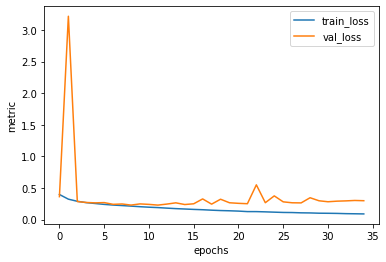

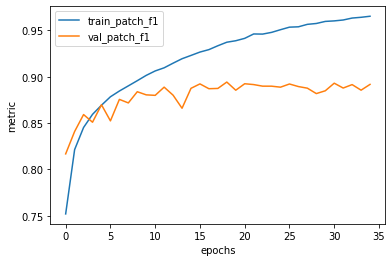

In [ ]:
plot_training_history(history)

In [ ]:
preds = predict_on_test_set(
    resnet_unet, 
    resize_shape=(384, 384), 
    normalize=True, 
    submission_fn="resnet18_unet_dilated_blocks.csv")

We obtain a score of 0.889 on the leaderboard, which is not an improvement of the original ResNet-UNet.

### Using dilated Bottleneck

In the following section, we organize the dilation blocks in a different way as a so called "dilated bottleneck": we replace the bottleneck of the ResNet-UNet with a structure composed of 3 dilated convolutions whose output is summed up at the end.

In [ ]:
resnet_unet = ResNet18UNet_DilatedResBottleneck().to(device)
history = train_model(
    model=resnet_unet,
    image_fns_train=image_fns[:-100],
    mask_fns_train=mask_fns[:-100],
    image_fns_val=image_fns[-100:],
    mask_fns_val=mask_fns[-100:],
    n_epochs=35,
    batch_size=4,
    resize_shape=(384, 384),
    normalize=True,
    plot_val_samples=False,
)

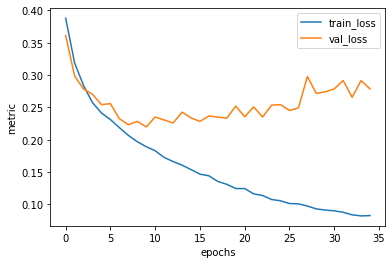

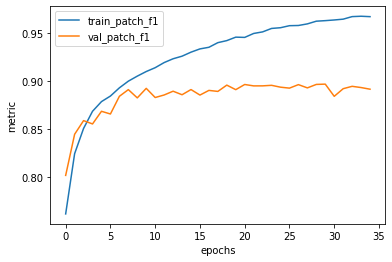

In [ ]:
plot_training_history(history)

In [ ]:
preds = predict_on_test_set(
    resnet_unet, 
    resize_shape=(384, 384), 
    normalize=True, 
    submission_fn="resnet18_unet_dilated_bottleneck.csv")

The F1 score we obtain in the leaderboard is 0.889. This represents no improvement compared to the previous approach.